
# Project: Genres and Movies

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This analysis is going to look at Block Buster Budget movies over $100,000,000 and what genres might determine if a movie will be profitable. The data set comes from IMDB's database and contains budget, revenue, director, cast, popularity, and IMDB voting information. However, this analysis will focus on attempting to find genres that can lead large budget films to profitability as well as look how genres have performed over time.  

> We are looking at two questions, 
### Which Genres were most popular in terms of number created movies? 
### Which Genres have been most profitable and most popular over time and which are most profitable today?



In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [3]:
movies_all = pd.read_csv('imdb-movies.csv')
movies_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [4]:

movies_all.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


## Data Cleaning

After looking at the dataset, there are a few columns that we do not need to include in our investigation. We are going to remove the budget and revenue columns as we are going to use the inflation adj columns instead to try as that adjusts the dollar amounts to 2010 and helps with normalization. Also we don't need the keywords, overview, tagline, homepage,overview,runtime, release_date(we will us the year instead), production_companies(many missing values) or imdb_id. For the purpose of this analysis we also are not looking into the popularity, or voting numbers on IMDB so this was also dropped from the Dataset.


In [5]:
movies_all.drop(['imdb_id','popularity','budget','revenue','cast','homepage','tagline','keywords','overview','runtime','release_date','vote_count',
                    'vote_average','production_companies'], axis=1, inplace=True)
movies_all.rename(columns={'budget_adj':'budget','revenue_adj':'revenue'},inplace=True)

movies_all.head()

,id,original_title,director,genres,release_year,budget,revenue
0,135397,Jurassic World,Colin Trevorrow,Action|Adventure|Science Fiction|Thriller,2015,1.379999e+08,1.392446e+09
1,76341,Mad Max: Fury Road,George Miller,Action|Adventure|Science Fiction|Thriller,2015,1.379999e+08,3.481613e+08
2,262500,Insurgent,Robert Schwentke,Adventure|Science Fiction|Thriller,2015,1.012000e+08,2.716190e+08
3,140607,Star Wars: The Force Awakens,J.J. Abrams,Action|Adventure|Science Fiction|Fantasy,2015,1.839999e+08,1.902723e+09
4,168259,Furious 7,James Wan,Action|Crime|Thriller,2015,1.747999e+08,1.385749e+09


### Budget Revenue and Profit
It is also noted that that there are movies either without budget information or revenue information and those were removed as well. We removed any of the rows that had na values as we need those values for comparision and also added a profit column by subtracting the budget from the revenue.

In [6]:
movies_all = movies_all.loc[movies_all['budget'] > 0]
movies_all = movies_all.loc[movies_all['revenue'] > 0]
#Check to make sure their are no values of 0
print(movies_all['budget'].min(),movies_all['revenue'].min())

0.969398042591 2.37070528957


In [7]:
#Create a profit column and drop na
movies_all['profit'] = movies_all['revenue'] - movies_all['budget']
movies_all.dropna(axis=0, inplace=True)
#format the budget, revenue and profit columns
movies_all.style.format({'profit':"{:,}","revenue":"{:,}",'budget':"{:,}"})
movies_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3854 entries, 0 to 10848
Data columns (total 8 columns):
id                3854 non-null int64
original_title    3854 non-null object
director          3854 non-null object
genres            3854 non-null object
release_year      3854 non-null int64
budget            3854 non-null float64
revenue           3854 non-null float64
profit            3854 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 431.0+ KB


## Splitting Genres
We also needed to make split the vaules of the Genres columns inorder to be able to compare these values as the were in strings separated by |. Once this was split, we could do some analysis.

In [8]:
#separate grenres using str.split
movies_all['genres'] = movies_all["genres"].str.split("|",  expand=True) 
movies_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3854 entries, 0 to 10848
Data columns (total 8 columns):
id                3854 non-null int64
original_title    3854 non-null object
director          3854 non-null object
genres            3854 non-null object
release_year      3854 non-null int64
budget            3854 non-null float64
revenue           3854 non-null float64
profit            3854 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 431.0+ KB


## Exploritory Data Analysis

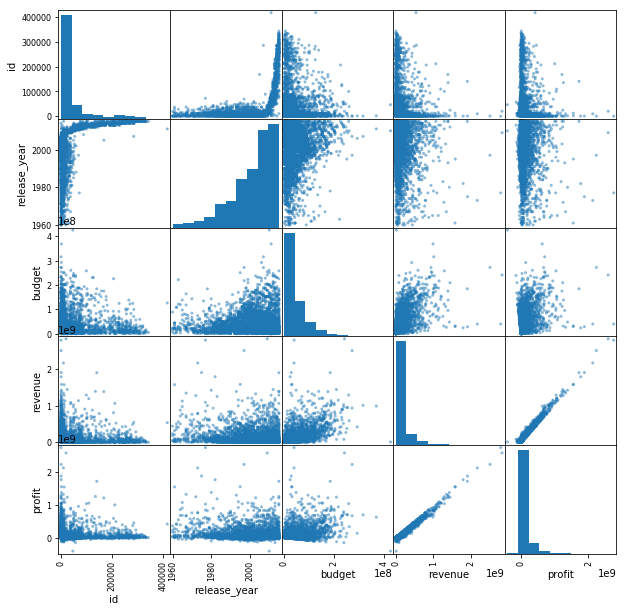

In [9]:
pd.plotting.scatter_matrix(movies_all, figsize=(10,10));

Here there doesn't seem to show too much of a correlation accept in profit and revenue. 

In [10]:
movies_all.hist(figsize=(10,10));`

SyntaxError: invalid syntax (<ipython-input-10-4326fd256c4c>, line 1)

Looking over the data above we can see that there are more movies coming out over time. We can also see that that profit, budget, and revenue are all skewed to the right in the histograms and that the best correlated data is revenue and profit, which makes sense. 

### Explortatory Questions
We then took a closer look at Budget and wanted to see what the top 5 most expensive movies were.

In [ ]:
movies_all['budget'].describe()

In [11]:
expensive = movies_all[['original_title','budget']].nlargest(5,'budget')
expensive

,original_title,budget
2244,The Warrior's Way,4.250000e+08
3375,Pirates of the Caribbean: On Stranger Tides,3.683713e+08
7387,Pirates of the Caribbean: At World's End,3.155006e+08
6570,Superman Returns,2.920507e+08
5231,Titanic,2.716921e+08


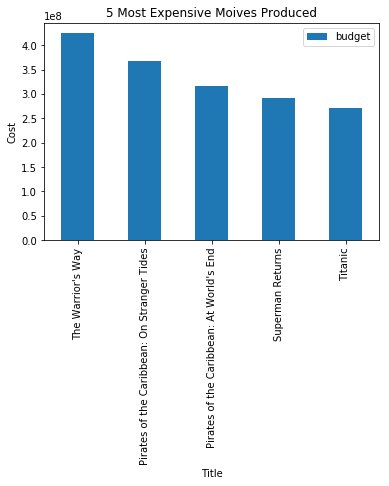

In [12]:
ex = expensive.plot(kind='bar', title="5 Most Expensive Moives Produced")
ex.set_xlabel('Title')
ex.set_ylabel('Cost')
ex.set_xticklabels(expensive.original_title);

From this, we found that The Warrior's Way was the most expensive along with two of the Pirates of the Carribean movies, Superman Returns and Titanic. 

We then wondered what the 5 movies had the most revenue as well.

In [13]:
movies_all['revenue'].describe()

count    3.854000e+03
mean     1.370621e+08
std      2.161130e+08
min      2.370705e+00
25%      1.835735e+07
50%      6.173068e+07
75%      1.632577e+08
max      2.827124e+09
Name: revenue, dtype: float64

In [14]:
rev = movies_all[['original_title','revenue']].nlargest(5,'revenue')
rev

,original_title,revenue
1386,Avatar,2.827124e+09
1329,Star Wars,2.789712e+09
5231,Titanic,2.506406e+09
10594,The Exorcist,2.167325e+09
9806,Jaws,1.907006e+09


In [18]:
low_rev = movies_all[['original_title','revenue']].nsmallest(5,'revenue')
low_rev

,original_title,revenue
5067,Shattered Glass,2.370705
8142,Mallrats,2.861934
3239,Dr. Horrible's Sing-Along Blog,3.038360
5162,Kid's Story,5.926763
8523,Bordello of Blood,6.951084


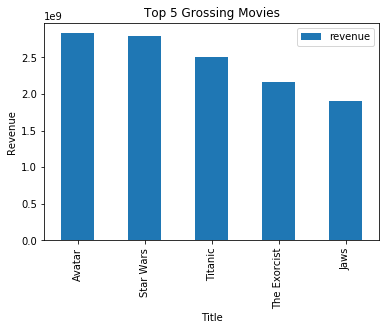

In [55]:
lx = rev.plot(kind='bar', title="Top 5 Grossing Movies")
lx.set_xlabel('Title')
lx.set_ylabel('Revenue')
lx.set_xticklabels(rev.original_title);

Here we Found that Avatar, Star Wars, Titanic, The Exorcist, and Jaws were the top grossing films in our list. 
Interestingly only Titanic was on both lists and many of these movies came from different genres.

### With Genres in mind we began to explore those a little further.

In [56]:
movies_all.groupby('genres').count()['id']

genres
Action             689
Adventure          314
Animation          103
Comedy             787
Crime              172
Documentary         32
Drama              889
Family              40
Fantasy            110
History             17
Horror             275
Music               29
Mystery             36
Romance             66
Science Fiction     98
Thriller           160
War                 20
Western             16
Name: id, dtype: int64

Once we grouped by Genres, we got a little more information.

## Question 1 What are the most Popular Genres of Movies Produced
Below we removed the TV Moves and found the most popular Genres and then use the top 5 for visualization

In [147]:
#because there is ony one entry for TV Movie we will remove that row
movies_all.drop(movies_all[movies_all.genres == "TV Movie"].index, inplace=True)
movies_all.groupby('genres').count()['id'].sort_values()

genres
Western             16
History             17
War                 20
Music               29
Documentary         32
Mystery             36
Family              40
Romance             66
Science Fiction     98
Animation          103
Fantasy            110
Thriller           160
Crime              172
Horror             275
Adventure          314
Action             689
Comedy             787
Drama              889
Name: id, dtype: int64

In [148]:
pop = ['Drama','Comedy','Action','Adventure','Horror']
pop_genres = movies_all[movies_all.genres.isin(pop)].copy()
genres_data = pd.crosstab(pop_genres.release_year,pop_genres.genres, margins=True, margins_name="total")
genres_data

genres,Action,Adventure,Comedy,Drama,Horror,total
release_year,,,,,,
1960,2,0,2,1,0,5
1961,1,1,3,2,1,8
1962,0,2,0,2,0,4
1963,2,1,1,1,1,6
1964,0,1,2,3,0,6
1965,1,1,0,3,0,5
1966,2,1,0,1,0,4
1967,2,2,3,0,0,7
1968,1,2,0,2,1,6


## Genres Data
From the above table we can see that the most popular Genres overall are Drama, Comedy, and Action movies. To see that data overtime more easily we created the lineplot below.

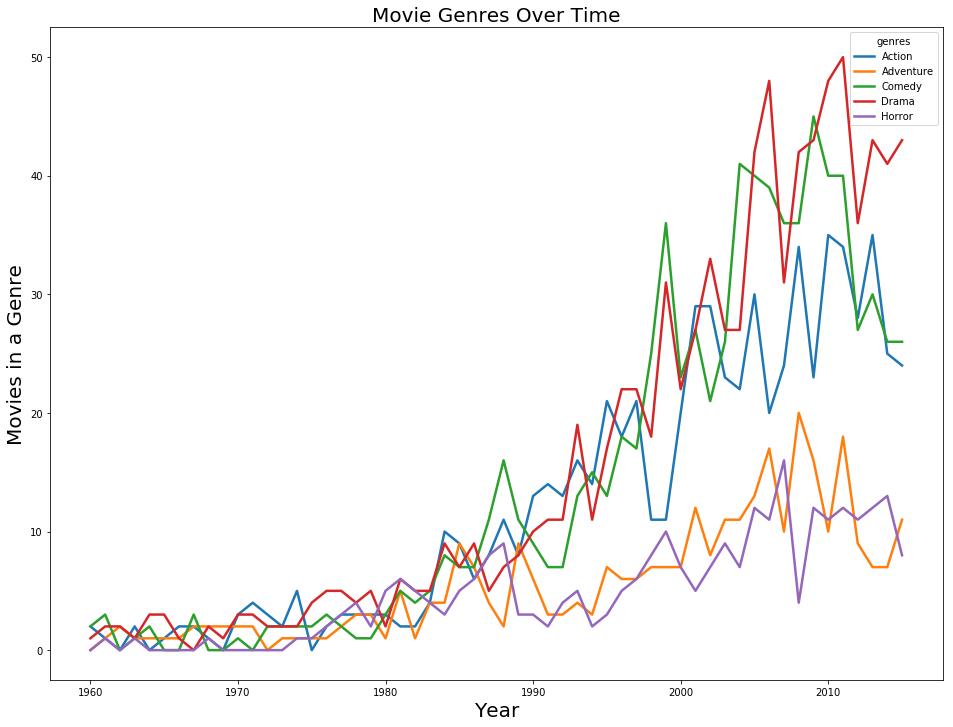

In [149]:
genres_plot = pd.crosstab(pop_genres.release_year,pop_genres.genres)
ax = genres_plot.plot(kind='line',figsize=(16,12), lw=2.5)
ax.set_title("Movie Genres Over Time", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Movies in a Genre", fontsize=20);

### Decades
Becuase there are are a lot of years in the dataset, we also decided to try adding a decade column and looking at our data again.


In [150]:
bin_edges=[1960,1969,1979,1989,1999,2009,2019]
bin_names=['1960s','1970s','1980s','1990s','2000s','2010s'] 
movies_all['decade'] = pd.cut(movies_all['release_year'], bin_edges, labels=bin_names, include_lowest=True)
movies_all.groupby('decade').count()['id']

decade
1960s      71
1970s     133
1980s     395
1990s     754
2000s    1459
2010s    1041
Name: id, dtype: int64

Here we found that more movies are being producde overtime. Since the 2010s are not over yet, we don't have
complete data for that decade yet.

In [151]:
genres_decades = pd.crosstab(movies_all.genres,movies_all.decade)
genres_decades

decade,1960s,1970s,1980s,1990s,2000s,2010s
genres,,,,,,
Action,11,28,63,152,254,181
Adventure,13,16,46,52,125,62
Animation,0,3,5,12,44,39
Comedy,11,16,77,160,334,189
Crime,6,11,17,38,54,46
Documentary,0,0,2,3,17,10
Drama,16,35,63,172,342,261
Family,1,1,4,6,14,14
Fantasy,0,1,18,29,38,24


Text(96,0.5,'Genres')

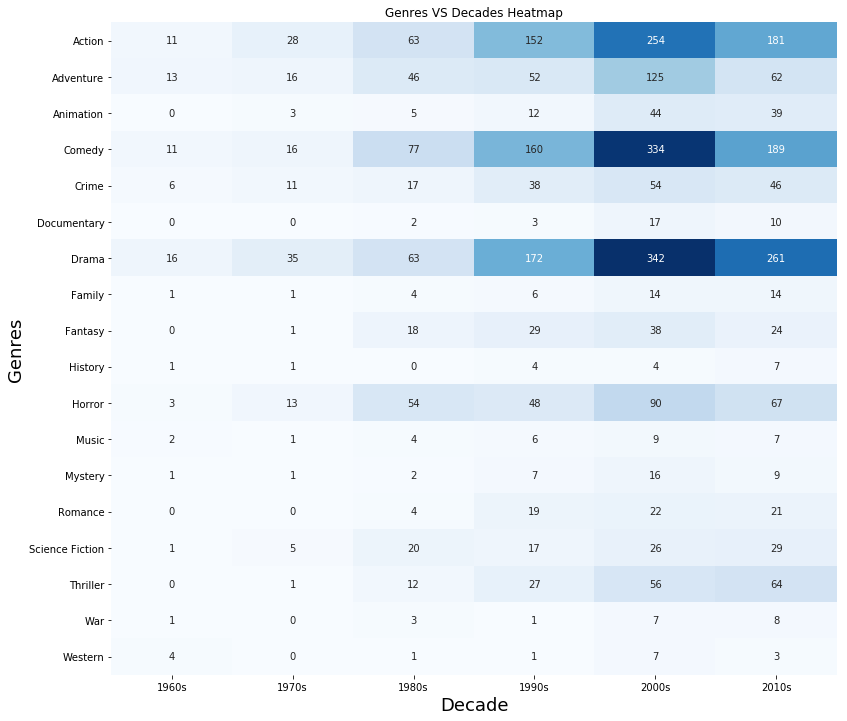

In [152]:
a4_dims = (13,12)
fig, size = pyplot.subplots(figsize=a4_dims)
heat = sns.heatmap(ax=size, data=genres_decades,cmap="Blues", annot=True, cbar=False,fmt='g').set_title("Genres VS Decades Heatmap");
plt.xlabel('Decade', fontsize=18)
plt.ylabel('Genres', fontsize=18)

## Findings 
It's also important to notes
What we find here is that the number of movies is indeed increasing over time. We also can see that certain genres are being made much more often today than when film began. 
We can also see the the most popular genres to create today are Drama, Comedy, Action. 
Adventure, Horror, Science Fiction and Thriller are all being created more often as well.It's importnat to note that there are more movies being created at the end of the dataset in genreal than there were at the begninng of the dataset. 

In 1960, we can also see that there were only a few genres: Comedy, Action, Drama, music, and Science Fiction. Most of the other categories starting showing up after 1980.

## Question 2: Which Genres are the most profitable and how has that changed over time?
Now what we have some data about the popularity of creating big budget movies in specific genres, it might be good to see what genres make the most money and how that has changed over time. 


In [199]:
g_profit=movies_all.groupby('genres')['profit'].sum()
top= g_profit.nlargest(10)
top.sort_values(ascending=False)

genres
Action             7.000053e+10
Adventure          6.845165e+10
Comedy             5.473410e+10
Drama              5.346395e+10
Animation          2.168894e+10
Horror             1.630987e+10
Science Fiction    1.515699e+10
Fantasy            1.433064e+10
Crime              1.136188e+10
Thriller           8.528993e+09
Name: profit, dtype: float64

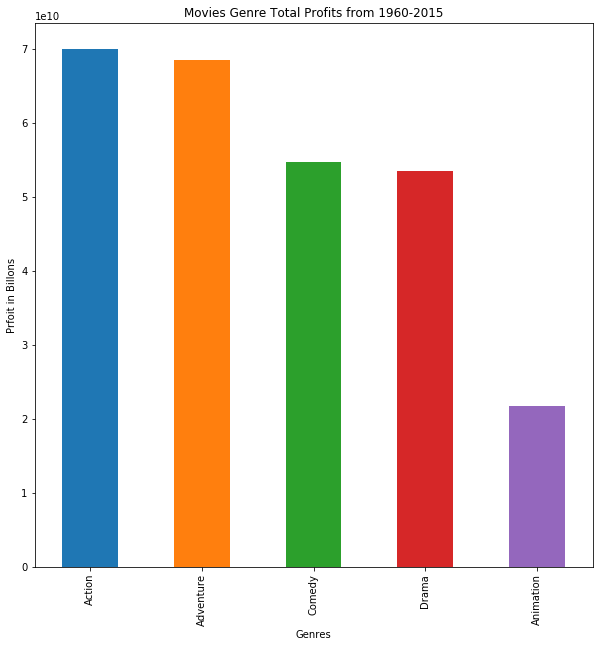

In [154]:
gbar = top.plot(kind='bar', figsize=(10,10))
gbar.set_xlabel("Genres")
gbar.set_ylabel("Prfoit in Billons")
gbar.set_title("Movies Genre Total Profits from 1960-2015");

In [155]:
lowest = g_profit.nsmallest(5)
lowest

genres
Documentary    5.985774e+08
Western        8.626980e+08
War            1.529514e+09
Mystery        1.828365e+09
History        2.008199e+09
Name: profit, dtype: float64

### Most Profitable 
From this data, we can see that Action, Adventure, Comedy, Drama and animation are our top earners of all time.
Doumentaries, War, and Westerns, Mystery and History are among the lowest earners.
Next we explore these numbers more by decade to get more insights over time. Grouping by decades made it easier to spot overall trends as seen below. However, it was intersting to see where certain genres lost money as well. 

We used the mean to fairly compare the genres over time, but also looked at total profit as well. 

In [200]:
tops = ['Action','Adventure','Comedy','Drama','Animation','Science Fiction']
top_prof= movies_all[movies_all.genres.isin(tops)].copy()
top_prof.head()
 

,id,original_title,director,genres,release_year,budget,revenue,profit,decade
0,135397,Jurassic World,Colin Trevorrow,Action,2015,1.379999e+08,1.392446e+09,1.254446e+09,2010s
1,76341,Mad Max: Fury Road,George Miller,Action,2015,1.379999e+08,3.481613e+08,2.101614e+08,2010s
2,262500,Insurgent,Robert Schwentke,Adventure,2015,1.012000e+08,2.716190e+08,1.704191e+08,2010s
3,140607,Star Wars: The Force Awakens,J.J. Abrams,Action,2015,1.839999e+08,1.902723e+09,1.718723e+09,2010s
4,168259,Furious 7,James Wan,Action,2015,1.747999e+08,1.385749e+09,1.210949e+09,2010s


In [201]:
genre_profit = pd.crosstab(top_prof.release_year, top_prof.genres, values=top_prof.profit, aggfunc='mean').round(0).fillna(0)
genre_profit

genres,Action,Adventure,Animation,Comedy,Drama,Science Fiction
release_year,,,,,,
1960,187660454.0,0.000000e+00,0.0,96217225.0,2.299854e+08,0.0
1961,167052322.0,1.545635e+09,0.0,24559366.0,5.998693e+07,0.0
1962,0.0,4.090795e+08,0.0,0.0,8.830350e+06,0.0
1963,247065827.0,7.120179e+06,0.0,67460766.0,1.896460e+08,0.0
1964,0.0,8.534745e+08,0.0,340171004.0,1.678834e+08,0.0
1965,168515726.0,9.010273e+08,0.0,0.0,5.645708e+08,0.0
1966,31396642.0,4.625353e+07,0.0,0.0,1.762585e+08,0.0
1967,400000219.0,6.780166e+07,0.0,332424438.0,0.000000e+00,0.0
1968,230703334.0,1.281860e+08,0.0,0.0,2.089027e+07,280319034.0


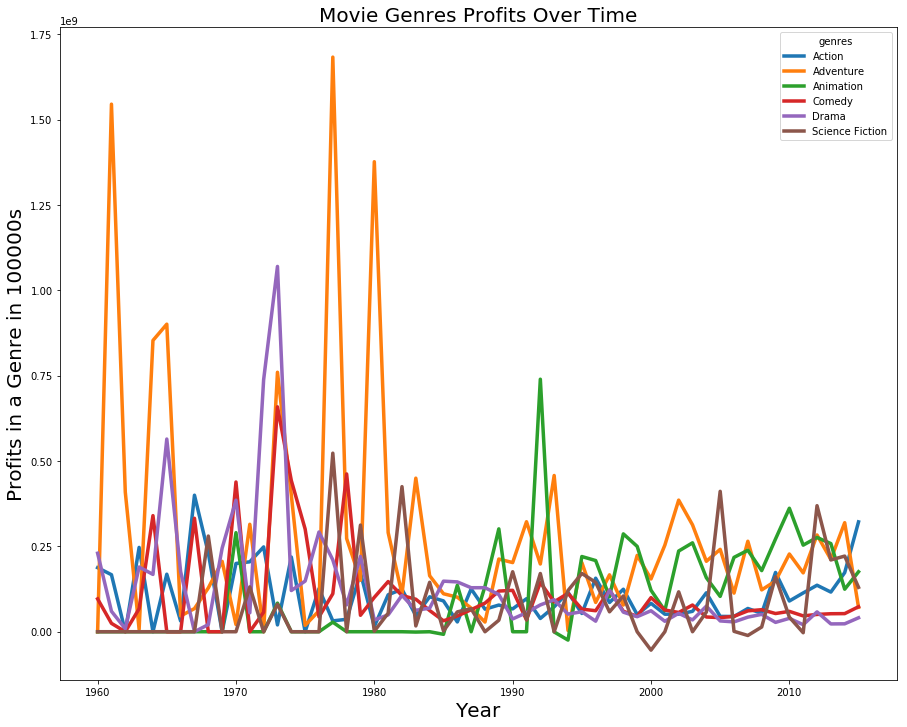

In [202]:
gp = genre_profit.plot(kind='line',figsize=(15,12), lw=3.5)
gp.set_title("Movie Genres Profits Over Time", fontsize=20)
gp.set_xlabel("Year", fontsize=20)
gp.set_ylabel("Profits in a Genre in 100000s", fontsize=20);


In [205]:

decade_profits = pd.crosstab(top_prof.genres, top_prof.decade, values=top_prof.profit, aggfunc='mean', margins=True, margins_name='total').round(0).fillna(0)
#created a function to quickly see and negative values taken from https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: green'` for positive
    strings, black negative.
    """
    color = 'green' if val > 0 else 'red'
    return 'color: %s' % color
decade_profits.style.applymap(color_negative_red)

decade,1960s,1970s,1980s,1990s,2000s,2010s,total
genres,,,,,,,
Action,2.08956e+08,1.52612e+08,8.0369e+07,8.67277e+07,7.17861e+07,1.48891e+08,1.01597e+08
Adventure,3.82769e+08,4.09415e+08,2.03386e+08,1.85893e+08,2.0372e+08,2.00611e+08,2.17999e+08
Animation,0,1.34019e+08,1.12417e+08,2.0482e+08,1.93359e+08,2.50234e+08,2.10572e+08
Comedy,1.82835e+08,2.63931e+08,8.23766e+07,7.70818e+07,5.79213e+07,5.54402e+07,6.95478e+07
Drama,2.01093e+08,2.77297e+08,1.0482e+08,6.37354e+07,4.17492e+07,3.33206e+07,6.01394e+07
Science Fiction,2.80319e+08,3.14049e+08,1.39767e+08,1.19518e+08,8.83173e+07,2.13208e+08,1.54663e+08
total,9.79031e+07,2.5946e+08,7.83348e+07,8.96182e+07,1.12128e+08,2.45837e+08,9.84362e+07


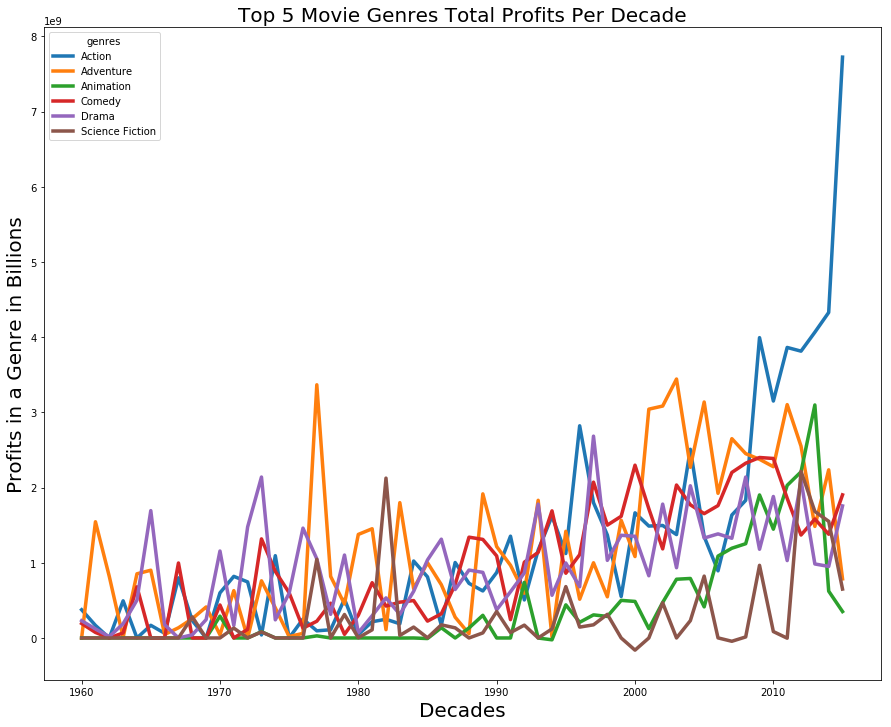

In [206]:
genre_sumprofits = pd.crosstab(top_prof.release_year, top_prof.genres, values=top_prof.profit, aggfunc='sum').round(0).fillna(0)
rs = genre_sumprofits.plot(kind='line',figsize=(15,12), lw=3.5)
rs.set_title("Top 5 Movie Genres Total Profits Per Decade", fontsize=20)
rs.set_xlabel("Decades", fontsize=20)
rs.set_ylabel("Profits in a Genre in Billions", fontsize=20);

## Question 2 Findings
It's clear which movie genres have been most profitable overall as explained above. However, when we add time to the investigation, we find a some interesting data. 
### Yearly Data 
>There are lots of interesting changes in movie profits over time when looking at year data.
##### In the 60s, Adventure movies were the most profitable along with Family Movies. 
##### In the 70s, Horror, Adventure and Dramas topped the list. 
##### In the 80s, we saw a spike in Scienece Fiction, and Fanasty, but Adventure and Dramas were still popular. What is interesting is that there was and overall decline in average movie profit in the 80s. 
##### In the 90s, Romance and Animation, Family , Mystery and Crime movies saw the biggest spike in average profit.
##### After the 2000s as more movies were being made, the average profits largely leveled off. However, Science Fiction, Animation, Fantasy, War, and Dramas all did relatively well. 

### Data Groupby By Decade
>Looking at the data by Decade allowed us to make better conclusions overall about the profitability of different movie genres.
##### We found that Adventure, Comdey, Action, Animation and Drama have been the move profitable genres
#### Animation and Science Fiction are trending genres in terms of profitability. 



## Limitations
Unfortunatley there were several issues and limitations to this data set and therefore could cause the conclusions to be inaccurate. 

>-There were several thousand rows that were missing data in the revenue section and therefore had to be removed. The numbers would have been more skewed by placing means in for these missing values
-There were also about a thousand missing values for the Budget which causes the same issues as above
-Further, the movies had multiple classifications in there Genres which could also lead to issues as to accurate categorization. for this Analyis we used the value listed first.
-With having to remove all of those values and possible misclassification there were some small numbers for certain movie genres

Therefore we need to know that these findings are potentially not accurate.

<a id='conclusions'></a>
## Conclusions (All Findings are Tenetive)

>While these are only tenetive numbers as we don't have all the data for all of the movies in this set, we can make a few conclusions. 

>First, the number of movies released seems to be growing over time, but average Profits in each genre seem to have largely leveled off. 

>When we looking at total earnings  Adventure, Action, Drama, and Comdey have performed the most consistantly over time. Animation, Science Fiction, Drama and Adventure movies see the highest Average Profits today with Action and Adventure Movies pulling in the most profits. 

>Also of interest is that Westerns and War movies were the only category to lose money over a decade, but both are doing well today.

In [207]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0